In [ ]:
from typing import Optional

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tomllib
import yaml
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from shapely.geometry import Polygon

with open("plotting_config.toml", "rb") as fp:
    config = tomllib.load(fp)


def plot_grid(
    grid: gpd.GeoDataFrame,
    column: str,
    cmap: str,
    figsize: tuple[float, float],
    missing_kwds: Optional[dict] = None,
    axes: Optional[plt.Axes] = None,
) -> tuple[plt.Figure, plt.Axes]:
    if axes:
        ax = axes
        fig = ax.get_figure()
    else:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    grid.plot(column=column, cmap=cmap, aspect=None, ax=ax, missing_kwds=missing_kwds)
    ax.axis("off")
    ax.margins(0)
    fig.patch.set_visible(False)
    return fig, ax

In [3]:
CRS = 2449
x_ratio = 0.9
y_ratio = 1.1

In [5]:
grid = gpd.read_file(f"../data/yjmob100k/grid_bl_{CRS}.geojson", engine="pyogrio")
grid.set_crs(CRS, inplace=True)

activity = pd.read_csv("../data/yjmob100k/activity.csv", engine="pyarrow")
unique_users = pd.read_csv("../data/yjmob100k/unique_users.csv", engine="pyarrow")

In [ ]:
grid_area = gpd.GeoDataFrame(geometry=[grid.union_all()])

In [7]:
activity["activity_count_log"] = activity["count"].apply(np.log10).fillna(0)
unique_users["users_count_log"] = unique_users["count"].apply(np.log10).fillna(0)

In [8]:
grid2 = grid.merge(
    activity[["x", "y", "activity_count_log"]], on=["x", "y"], how="left"
)
grid2["activity_count_log"] = grid2["activity_count_log"].fillna(0)

grid2 = grid2.merge(
    unique_users[["x", "y", "users_count_log"]], on=["x", "y"], how="left"
)
grid2["users_count_log"] = grid2["users_count_log"].fillna(0)

grid2 = grid2.merge(activity[["x", "y", "count"]], on=["x", "y"], how="left")
grid2.rename({"count": "activity_count"}, axis=1, inplace=True)
grid2 = grid2.merge(unique_users[["x", "y", "count"]], on=["x", "y"], how="left")
grid2.rename({"count": "users_count"}, axis=1, inplace=True)

grid2["users_count"] = grid2["users_count"].fillna(0)
grid2["activity_count"] = grid2["activity_count"].fillna(0)

grid2["activity_count_bin"] = grid2["activity_count"].apply(
    lambda x: 0 if x < 75 else 1
)
# grid2["users_count_bin"] = grid2["users_count"].apply(lambda x: 0 if x < 75 else 1)

grid2["users_count_log_selective"] = grid2.apply(
    lambda x: np.nan
    if x["activity_count"] < 75 or pd.isna(x["activity_count"])
    else x["users_count_log"],
    axis=1,
)
grid2["activity_count_log_selective"] = grid2.apply(
    lambda x: np.nan
    if x["activity_count"] < 75 or pd.isna(x["activity_count"])
    else x["activity_count_log"],
    axis=1,
)

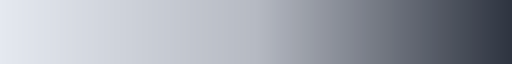

In [9]:
colors = ['#d8dee9', '#2e3440']
colors = ['#e5e9f0', '#2e3440']
positions = [0, 1]
colors = ['#e5e9f0', "#b6bac3", '#2e3440']
positions = [0, 0.5, 1]
cmap = LinearSegmentedColormap.from_list('nord-based', list(zip(positions, colors)))
cmap

In [10]:
# grid2["q"] = pd.qcut(grid2["users_count"], q=12, labels=[i for i in range(11)], duplicates="drop")
grid2["q"] = pd.qcut(grid2["users_count"], q=10, duplicates="drop")


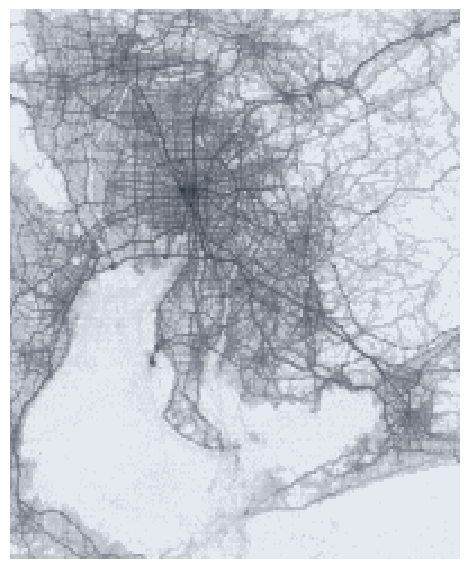

In [11]:
fig, ax = plot_grid(
    grid2, "users_count_log", cmap, figsize=(5 * x_ratio, 5 * y_ratio)
)

In [ ]:
for i in ["png"]:
    fig.savefig(
        f"../web/static/images/nagoya_blue.{i}",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

In [48]:
from common import calculate_image_size, generate_grid


def plot_landuse_img(
    landuse: gpd.GeoDataFrame,
    large: Polygon,
    figsize: tuple[float, float] = (5, 5),
    dpi: int = 300,
    land_color: str = "#000000",
    background: bool = True,
) -> tuple[plt.Figure, plt.Axes]:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    if background:
        gpd.GeoDataFrame(geometry=[large], crs=CRS).plot(
            color="white", aspect=None, ax=ax, zorder=1
        )
    gpd.clip(
        landuse.query("landuse.isin(['residential', 'retail', 'industrial'])"), large
    ).plot(color=land_color, aspect=None, ax=ax, zorder=5)
    ax.margins(0)
    ax.axis("off")
    ax.set_facecolor("white")
    fig.patch.set_visible(False)
    return fig, ax


def prepare_helsinki():
    CRS = 3067
    rx, ry = 250, 250
    data = pd.read_csv(
        "../data/helsinki/HMA_Dynamic_population_24H_workdays.csv", engine="pyarrow"
    )
    grid = gpd.read_file(
        "../data/helsinki/target_zones_grid250m_EPSG3067.geojson", engine="pyogrio"
    )
    grid = grid.set_crs(CRS, allow_override=True)

    grid_c = grid.copy()
    grid_c["geometry"] = grid.geometry.centroid

    minx, miny, maxx, maxy = tuple(map(round, grid.union_all().bounds))
    # make it square
    maxy += 3000
    miny -= 6500
    area = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])

    large = area.buffer(75000).envelope
    large_crs = gpd.GeoDataFrame(geometry=[large], crs=CRS).geometry[0]

    W, H = calculate_image_size(large_crs.bounds, rx, ry)

    area_grid = generate_grid(minx, maxx, miny, maxy, rx, ry, crs=CRS)
    area_grid = area_grid.sjoin(grid_c, how="left").drop("index_right", axis=1)

    enriched_grid = area_grid.merge(data, on="YKR_ID", how="left")
    enriched_grid["H21"] = enriched_grid["H21"].fillna(0)

    enriched_grid["H21_bin"] = enriched_grid["H21"].apply(
        lambda x: 1 if x > 0.0025 else 0
    )

    return area, large_crs, enriched_grid


def anchor_to_poly(anchor: dict) -> Polygon:
    return Polygon(
        [
            (anchor["area"]["bounds"]["minx"], anchor["area"]["bounds"]["miny"]),
            (anchor["area"]["bounds"]["maxx"], anchor["area"]["bounds"]["miny"]),
            (anchor["area"]["bounds"]["maxx"], anchor["area"]["bounds"]["maxy"]),
            (anchor["area"]["bounds"]["minx"], anchor["area"]["bounds"]["maxy"]),
        ]
    )

In [9]:
cmap_a = ListedColormap(["#ffffff", "#d01c8b"])
cmap_l = ListedColormap(["#ffffff", "#4dac26"])

In [10]:
helsinki_area, helsinki_large, helsinki_activity = prepare_helsinki()

In [11]:
unioned = gpd.GeoDataFrame(geometry=[helsinki_activity.query("H21_bin>0").union_all()], crs=CRS)

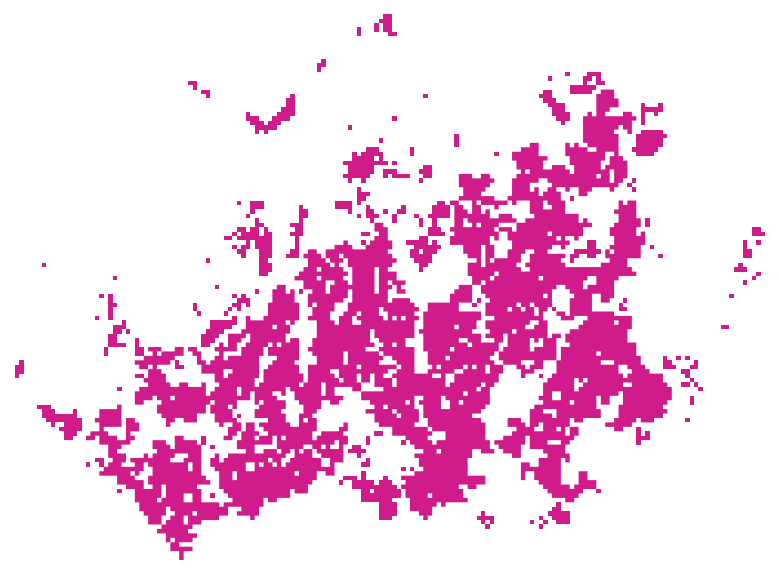

In [66]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
# helsinki_activity.plot(ax=ax, cmap=cmap_a, column="H21_bin", zorder=5)
# unioned.plot(ax=ax, color="#5e81ac", zorder=5)
unioned.plot(ax=ax, color=config["colors"]["activity"], zorder=5)
ax.margins(0)
ax.axis("off")
for i in config["formats"]:
    fig.savefig(
        f"../figures/helsinki_/activity.{i}",
        facecolor="none",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

In [26]:
landuse_hel = gpd.read_file("../data/helsinki/landuse_crs.geojson")

In [44]:
landuse_hel_unioned = landuse_hel.buffer(50).union_all()

In [45]:
landuse_hel_unioned_gdf = gpd.GeoDataFrame(geometry=[landuse_hel_unioned], crs=CRS)

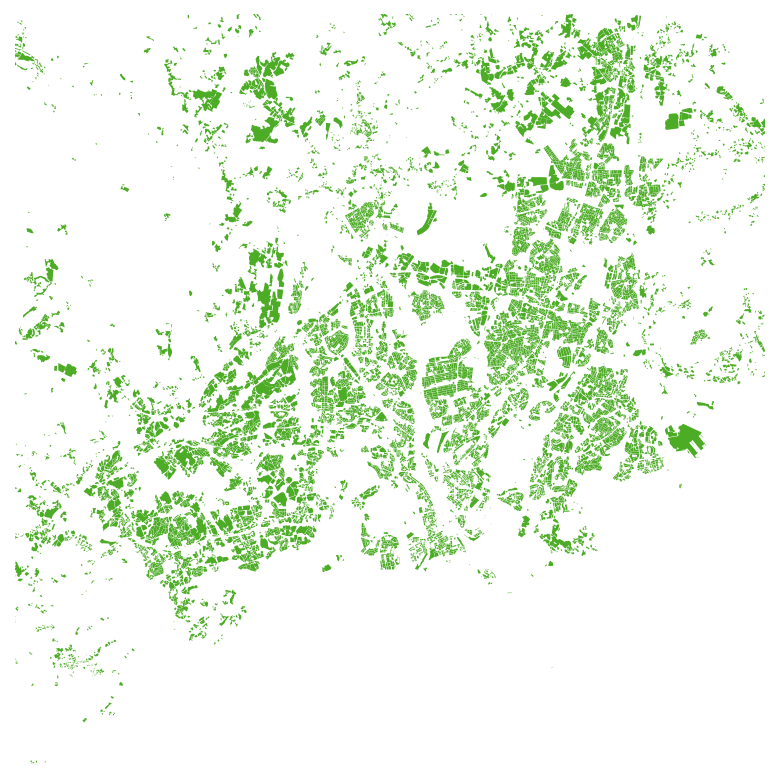

In [67]:
fig, ax = plot_landuse_img(landuse_hel, helsinki_large, dpi=150, land_color=config["colors"]["landuse"], background=False)
ax.set_xlim([helsinki_area.bounds[0], helsinki_area.bounds[2]])
ax.set_ylim([helsinki_area.bounds[1], helsinki_area.bounds[3]])
for i in config["formats"]:
    fig.savefig(
        f"../figures/helsinki_/landuse.{i}",
        facecolor="none",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

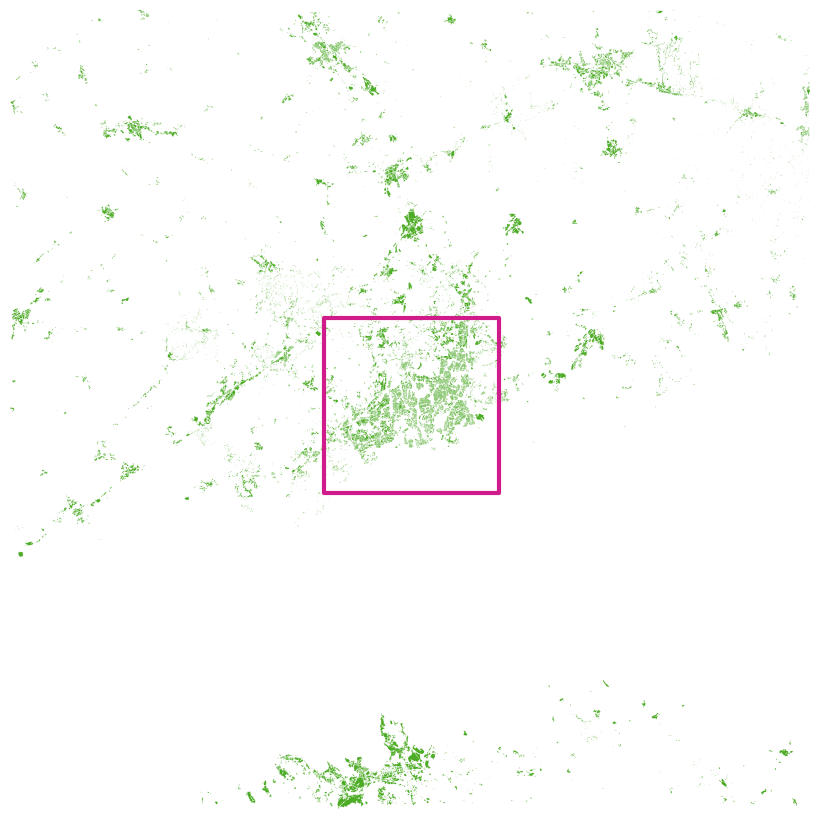

In [68]:
with open("../../../output/helsinki/anchor_500_500.yaml", "r") as fp:
    anchor_h = yaml.safe_load(fp)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
landuse_hel.plot(color=config["colors"]["landuse"], ax=ax)
gpd.GeoDataFrame(geometry=[anchor_to_poly(anchor_h)], crs=CRS).plot(
    fc="none", ec=config["colors"]["activity"], lw=3, ax=ax
)
ax.margins(0)
ax.axis("off")
for i in config["formats"]:
    fig.savefig(
        f"../figures/helsinki_/location.{i}",
        facecolor="none",
        pad_inches=0,
        metadata=config["metadata"][i],
)

In [27]:
weeplace = pd.read_csv("../data/weeplace/weeplace_checkins.csv", engine="pyarrow")
weeplace = gpd.GeoDataFrame(
    weeplace,
    geometry=gpd.points_from_xy(weeplace.lon, weeplace.lat, crs=4326),
    crs=4326,
)

In [149]:
activity = pd.read_csv("../output/activity.csv")

In [4]:
def foo(x):
    result = None
    if x["bin"] == x["bin_blur"] == 1:
        result = 1
    if x["bin"] == x["bin_blur"] == 0:
        result = 0
    if x["bin"] == 0 and x["bin_blur"] == 1:
        result = 2
    if x["bin"] == 1 and x["bin_blur"] == 0:
        result = -1
    return result


normal = gpd.read_file("../../../output/toronto/grid_1000_1000_enriched.geojson")
blurred = gpd.read_file("../../../output/toronto/noise/1000/grid_1000_1000_enriched.geojson")
m = normal[["x", "y", "bin", "geometry"]].merge(
    blurred[["x", "y", "bin"]], on=["x", "y"], suffixes=["", "_blur"]
)
m["c"] = m.apply(foo, axis=1)

In [2]:
from shapely import union_all

In [10]:
normal["bin"].unique()

array([0, 1], dtype=int32)

In [11]:
unioned_mormal = normal.groupby("bin")["geometry"].apply(union_all).reset_index()

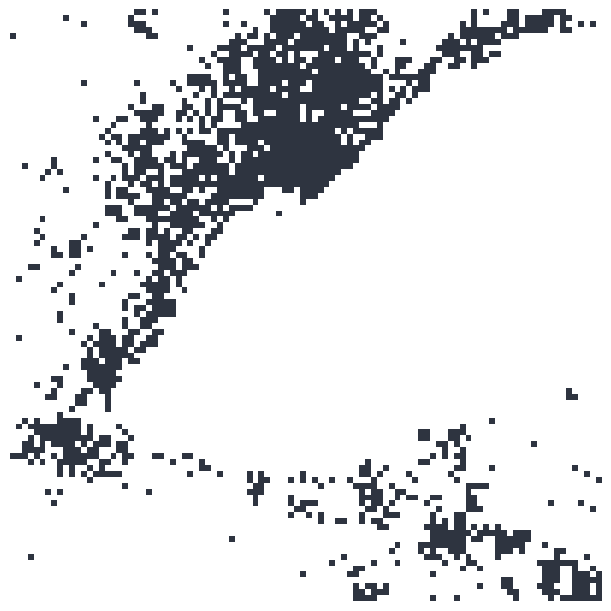

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
unioned_mormal.plot(column="bin", cmap=ListedColormap(["#ffffff","#2e3440"]), ax=ax)
ax.margins(0)
_ = ax.axis("off")
for i in ["png", "svg"]:
    fig.savefig(
        f"../figures/before_noise.{i}",
        dpi=300,
        pad_inches=0,
        metadata=config["metadata"][i],
    )

In [5]:
unioned_m = m.groupby("c")["geometry"].apply(union_all).reset_index()

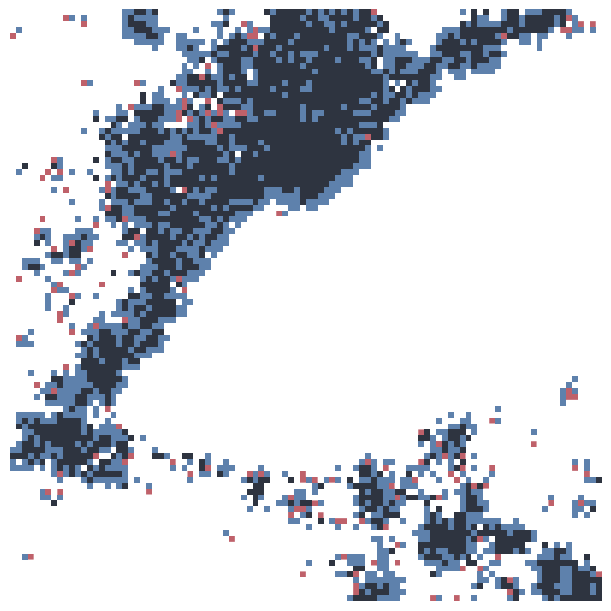

In [ ]:
cmap = ListedColormap(
    # [
    #     "red",
    #     "white",
    #     "black",
    #     "blue",
    # ]    
    [
        "#bf616a",
        # "#eceff4",
        "#ffffff",
        "#2e3440",
        "#5e81ac",
    ]
)
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
unioned_m.plot(column="c", cmap=cmap, ax=ax)
ax.margins(0)
_ = ax.axis("off")
for i in ["png", "svg"]:
    fig.savefig(
        f"../figures/noise_as_blur.{i}",
        dpi=300,
        pad_inches=0,
        metadata=config["metadata"][i],
    )